In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt



np.random.seed(1337) # for reproducibility

from tensorflow import set_random_seed
set_random_seed(1337)
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.layers import UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.
C:\Users\asdan\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\asdan\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\asdan\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\asdan\anaconda3\envs\ge

In [2]:
# Set some parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 5
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
#seed = 42
#random.seed = seed
#np.random.seed = seed

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [4]:
def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv



In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.figure(2)
    for l in dice_list:
        plt.plot(epochs, history.history[l], 'b', label='Training Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    plt.figure(3)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def ZF_UNET_224(dropout_val=0.2, weights=None):
    if K.image_data_format() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")

    #if weights == 'generator' and axis == 3 and INPUT_CHANNELS == 3 and OUTPUT_MASK_CHANNELS == 1:
    ##    weights_path = get_file(
     #       'zf_unet_224_weights_tf_dim_ordering_tf_generator.h5',
     #       ZF_UNET_224_WEIGHT_PATH,
     #       cache_subdir='models',
     #       file_hash='203146f209baf34ac0d793e1691f1ab7')
     #   model.load_weights(weights_path)

    return model

In [12]:
#X_validation = np.load("X_validation_ALL_RT224cti.npy")
#Y_validation = np.load("Y_validation_ALL_RT224cti.npy")
X_test = np.load("X_test224cti.npy")
Y_test = np.load("Y_test224.npy")
#X_validation = X_validation.astype('uint8')
#Y_validation = Y_validation.astype('uint8')
#X_test = X_test.astype('uint8')
#Y_test = Y_test.astype('uint8')

In [8]:
#X_validation = X_validation/255.0
#Y_validation = Y_validation/255.0
#X_test = X_test/255.0
#Y_test = Y_test/255.0

# All data 

In [7]:
X_train = np.load("13X_train224.npy")
Y_train = np.load("13Y_train224.npy")
X_train = X_train.astype('uint8')
Y_train = Y_train.astype('uint8')

In [8]:
model = ZF_UNET_224()
learning_rate =0.0001
patience = 20
model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('unetLr03.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]
# Fit model
results_03 = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=50,
                    callbacks=callbacks)

C:\Users\asdan\anaconda3\envs\geospatial\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Train on 105 samples, validate on 27 samples
Epoch 1/50
105/105 [==============================] - 291s 3s/step - loss: -0.0212 - dice_coef: 0.0217 - accuracy: 0.2920 - val_loss: -0.0063 - val_dice_coef: 0.0066 - val_accuracy: 0.3972
Epoch 2/50
105/105 [==============================] - 167s 2s/step - loss: -0.0289 - dice_coef: 0.0279 - accuracy: 0.4732 - val_loss: -0.0066 - val_dice_coef: 0.0070 - val_accuracy: 0.4044
Epoch 3/50
105/105 [==============================] - 164s 2s/step - loss: -0.0324 - dice_coef: 0.0331 - accuracy: 0.6103 - val_loss: -0.0069 - val_dice_coef: 0.0073 - val_accuracy: 0.3766
Epoch 4/50
105/105 [==============================] - 164s 2s/step - loss: -0.0355 - dice_coef: 0.0352 - accuracy: 0.7106 - val_loss: -0.0073 - val_dice_coef: 0.0077 - val_accuracy: 0.3937
Epoch 5/50
105/105 [==============================] - 166s 2s/step - loss: -0.0405 - dice_coef: 0.0402 - accuracy: 0.7887 - val_loss: -0.0076 - val_dice_coef: 0.0080 - val_accuracy: 0.3598
Epoch 6/5

105/105 [==============================] - 165s 2s/step - loss: -0.0987 - dice_coef: 0.0981 - accuracy: 0.9900 - val_loss: -0.0281 - val_dice_coef: 0.0302 - val_accuracy: 0.9974
Epoch 43/50
105/105 [==============================] - 166s 2s/step - loss: -0.0947 - dice_coef: 0.0975 - accuracy: 0.9902 - val_loss: -0.0296 - val_dice_coef: 0.0319 - val_accuracy: 0.9975
Epoch 44/50
105/105 [==============================] - 165s 2s/step - loss: -0.0968 - dice_coef: 0.0987 - accuracy: 0.9871 - val_loss: -0.0309 - val_dice_coef: 0.0330 - val_accuracy: 0.9962
Epoch 45/50
105/105 [==============================] - 164s 2s/step - loss: -0.0985 - dice_coef: 0.0963 - accuracy: 0.9893 - val_loss: -0.0300 - val_dice_coef: 0.0319 - val_accuracy: 0.9969
Epoch 46/50
105/105 [==============================] - 167s 2s/step - loss: -0.1000 - dice_coef: 0.0973 - accuracy: 0.9901 - val_loss: -0.0319 - val_dice_coef: 0.0340 - val_accuracy: 0.9966
Epoch 47/50
105/105 [==============================] - 165s 2s

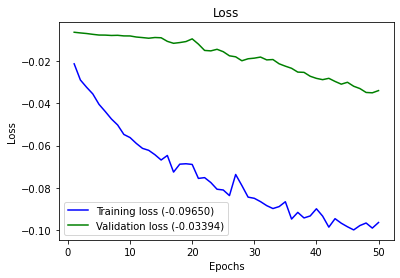

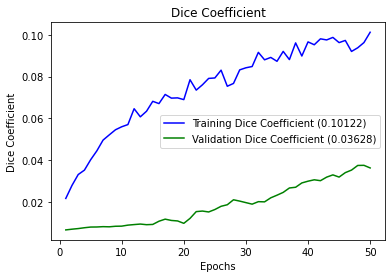

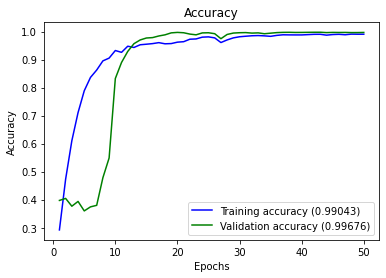

In [37]:
plot_history(results_03)

In [97]:
np.save("SL_results_143.npy",results_03.history)

In [102]:
model.save('attempt3preseparation.h5')
model.save_weights("weights.h5")

In [105]:
#why this error
ttmodel= load_model('weights.h5',compile=False)

ValueError: Cannot create group in read-only mode.

In [42]:
X_test = np.load("2X_test224cti.npy")
Y_test = np.load("2Y_test224.npy")
X_test = X_test.astype('uint8')
Y_test = Y_test.astype('uint8')

In [11]:
X_test.shape

(360, 224, 224, 5)

In [46]:
for i in range(0,Y_test.shape[0]):
    print(str(i)+": "+str(np.sum(Y_test[i])))

0: 0
1: 0
2: 0
3: 0
4: 0
5: 1452
6: 0
7: 0
8: 0
9: 0
10: 1392
11: 0
12: 0
13: 0
14: 0
15: 0
16: 1408
17: 0
18: 0
19: 2421
20: 1058
21: 1243
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 1649
34: 0
35: 353
36: 0
37: 0
38: 0
39: 0
40: 1360
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 0
49: 0
50: 0
51: 0
52: 0
53: 0
54: 0
55: 0
56: 0
57: 0
58: 0
59: 0
60: 1454
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 0
69: 0
70: 0
71: 0
72: 0
73: 0
74: 155
75: 1086
76: 0
77: 0
78: 0
79: 0
80: 1444
81: 0
82: 0
83: 0
84: 0
85: 0
86: 1675
87: 0
88: 0
89: 1315
90: 0
91: 0
92: 48
93: 0
94: 1571
95: 1272
96: 0
97: 0
98: 0
99: 1164
100: 0
101: 0
102: 585
103: 0
104: 0
105: 0
106: 265
107: 0
108: 0
109: 0
110: 0
111: 0
112: 0
113: 0
114: 0
115: 0
116: 1845
117: 0
118: 1497
119: 1580
120: 0
121: 0
122: 0
123: 0
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 1722
133: 0
134: 797
135: 1317
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 1442
144: 0
145: 0
146: 0
147:

In [43]:
preds_test = model.predict(X_test)

In [110]:
preds_test.shape

(132, 224, 224, 1)

In [44]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [45]:
for i in range(0,preds_test_t.shape[0]):
    print(str(i)+": "+str(np.sum(preds_test_t[i])))

0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 9
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 0
34: 0
35: 0
36: 0
37: 0
38: 0
39: 0
40: 0
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 0
49: 0
50: 0
51: 0
52: 0
53: 0
54: 0
55: 0
56: 0
57: 0
58: 0
59: 0
60: 0
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 0
69: 0
70: 0
71: 0
72: 0
73: 0
74: 0
75: 0
76: 0
77: 0
78: 0
79: 0
80: 306
81: 0
82: 0
83: 0
84: 0
85: 0
86: 0
87: 0
88: 0
89: 0
90: 0
91: 0
92: 0
93: 0
94: 0
95: 0
96: 0
97: 0
98: 0
99: 0
100: 0
101: 0
102: 0
103: 0
104: 0
105: 0
106: 220
107: 0
108: 0
109: 0
110: 0
111: 0
112: 0
113: 0
114: 0
115: 0
116: 0
117: 0
118: 0
119: 0
120: 0
121: 0
122: 0
123: 0
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 0
133: 0
134: 0
135: 0
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 0
144: 0
145: 0
146: 0
147: 0
148: 0
149: 0
150: 0
151: 0
152: 0
153: 0
154: 0
155: 0
156: 0
157: 0


In [36]:
#preds_test_t.shape=(132,224,224,1)
print(preds_test_t.shape)
print(np.max(preds_test[8]))

(132, 224, 224, 1)
1.0


In [38]:
Y_train = np.load("11Y_train224.npy")
Y_train = Y_train.astype('uint8')
#Y_test = np.load("Y_test224.npy")
#Y_test= Y_train.astype('uint8')

In [47]:
mappedResult = []
for i in range(0,X_test.shape[0]):
    curGT = Y_test[i]
    curPD = preds_test_t[i]
    values = curGT.copy()
    #print(curGT.shape)
    #print(curPD.shape)
    for x in range(0,IMG_WIDTH):
        for y in range(0,IMG_WIDTH):
            if curGT[x,y]==0 and curPD[x,y]==0:
                #print("here")
                values[x,y] = 0
            elif curGT[x,y]==0 and curPD[x,y]==1:
                #print("here1")
                values[x,y] = 1
            elif curGT[x,y]==1 and curPD[x,y]==0:
                #print("here2")
                values[x,y] = 2
            elif curGT[x,y]==1 and curPD[x,y]==1:
                values[x,y] = 3
    mappedResult.append(values)
    
mappedResult = np.asarray(mappedResult)

In [70]:
mappedResult.shape

(132, 224, 224, 1)

In [48]:
for i in range(mappedResult.shape[0]):
    print(str(i)+": "+str(np.max(mappedResult[i])))

0: 0
1: 0
2: 0
3: 0
4: 0
5: 2
6: 0
7: 0
8: 0
9: 0
10: 2
11: 0
12: 0
13: 0
14: 0
15: 0
16: 3
17: 0
18: 0
19: 2
20: 2
21: 2
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 2
34: 0
35: 2
36: 0
37: 0
38: 0
39: 0
40: 2
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 0
49: 0
50: 0
51: 0
52: 0
53: 0
54: 0
55: 0
56: 0
57: 0
58: 0
59: 0
60: 2
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 0
69: 0
70: 0
71: 0
72: 0
73: 0
74: 2
75: 2
76: 0
77: 0
78: 0
79: 0
80: 3
81: 0
82: 0
83: 0
84: 0
85: 0
86: 2
87: 0
88: 0
89: 2
90: 0
91: 0
92: 2
93: 0
94: 2
95: 2
96: 0
97: 0
98: 0
99: 2
100: 0
101: 0
102: 2
103: 0
104: 0
105: 0
106: 3
107: 0
108: 0
109: 0
110: 0
111: 0
112: 0
113: 0
114: 0
115: 0
116: 2
117: 0
118: 2
119: 2
120: 0
121: 0
122: 0
123: 0
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 2
133: 0
134: 2
135: 2
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 2
144: 0
145: 0
146: 0
147: 0
148: 0
149: 0
150: 0
151: 0
152: 0
153: 0
154: 0
155: 0
156: 0
157: 0
158:

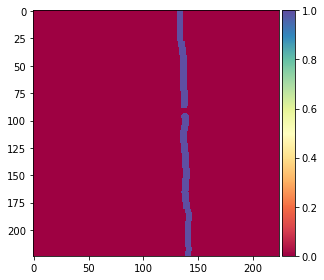

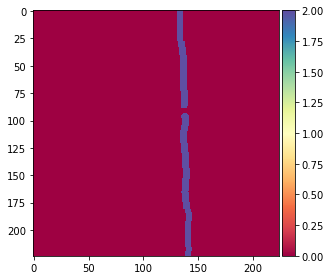

In [50]:
ix = 135
#imshow(np.squeeze(X_train[ix]))
#plt.show()
imshow(np.squeeze(Y_test[ix]),cmap=plt.cm.Spectral)
plt.show()
#imshow(np.squeeze(preds_test_t[ix]),cmap=plt.cm.Spectral)
#plt.show()
imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
plt.show()

In [38]:
preds_test_mod = preds_test_t
preds_test_mod.shape = preds_test_mod.shape[0] * 224*224 ,1
preds_test_mod2  = preds_test_mod.tolist()
predictionlist = [item for sublist in preds_test_mod2 for item in sublist]

In [39]:
groundtruth = Y_test
groundtruth.shape = groundtruth.shape[0] * 224*224 ,1
groundtruth  = groundtruth.tolist()
groundtruthlist = [item for sublist in groundtruth for item in sublist]

In [22]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
cm = confusion_matrix(groundtruthlist, predictionlist)

In [63]:
cm


array([[6553872,   35969],
       [   5018,   28373]], dtype=int64)

Confusion matrix, without normalization
[[18015186      264]
 [   47533      377]]


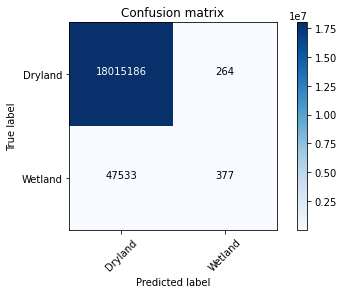

In [41]:
plot_confusion_matrix(cm,classes=["Dryland","Wetland"])

In [25]:
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.8390829077026141
0.5214804199507773
0.9998766649277188
0.9842224922582415
0.9929886598267554


In [92]:
#new confusion Matrix with cti
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(f1_score(groundtruthlist, predictionlist,pos_label=1))
print(f1_score(groundtruthlist, predictionlist,pos_label=0))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.6091106692851627
0.22630879927609204
0.9919125392942334
0.13407115991526522
0.9990975135599625
0.725291173581552
0.9848301681361279


In [33]:
from sklearn.metrics import accuracy_score
print(accuracy_score(groundtruthlist, predictionlist))


0.9830729166666666


In [107]:
sum(groundtruthlist)

155955

In [109]:
len(groundtruthlist)

602112

In [110]:
len(groundtruthlist)-sum(groundtruthlist)

446157

In [34]:
print(f1_score(groundtruthlist, predictionlist, pos_label=1))

0.2750504371217216


In [35]:
print(f1_score(groundtruthlist, predictionlist, pos_label=0))

0.9914364821503755


In [36]:
a = f1_score(groundtruthlist, predictionlist, pos_label=1)
b= f1_score(groundtruthlist, predictionlist, pos_label=0)
c =(a+b)/2
c

0.6332434596360486

In [10]:
model = load_model('unetLr03.h5', custom_objects={'dice_coef': dice_coef,'dice_coef_loss':dice_coef_loss})

TypeError: ('Keyword argument not understood:', 'interpolation')

In [ ]:
preds_test = model.predict(X_train)

In [11]:
preds_test.shape

NameError: name 'preds_test' is not defined

In [ ]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
mappedResult = []
for i in range(0,X_train.shape[0]):
    curGT = Y_train[i]
    curPD = preds_test_t[i]
    values = curGT.copy()
    for x in range(0,IMG_WIDTH):
        for y in range(0,IMG_WIDTH):
            if curGT[x,y]==0 and curPD[x,y]==0:
                #print("here")
                values[x,y] = 0
            elif curGT[x,y]==0 and curPD[x,y]==1:
                #print("here1")
                values[x,y] = 1
            elif curGT[x,y]==1 and curPD[x,y]==0:
                #print("here2")
                values[x,y] = 2
            elif curGT[x,y]==1 and curPD[x,y]==1:
                values[x,y] = 3
    mappedResult.append(values)
    
mappedResult = np.asarray(mappedResult)

# TestMap

In [4]:
Y_test = np.load("Y_testMap.npy")


FileNotFoundError: [Errno 2] No such file or directory: 'TestmappedResult'

In [5]:
mappedResult = np.load("TestmappedResult.npy")

In [14]:
Y_test = Y_test.astype('uint8')
mappedResult =mappedResult.astype('uint8')

757


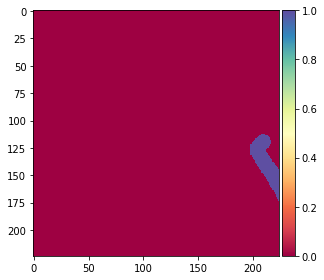

758


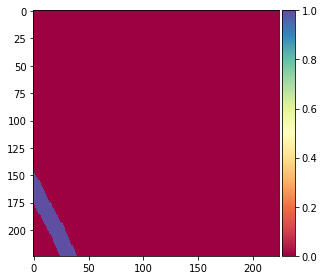

820


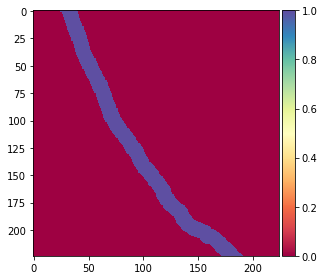

882


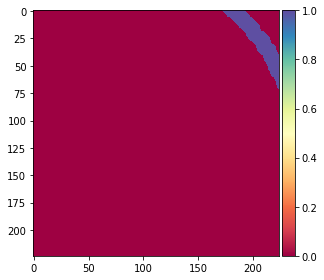

883


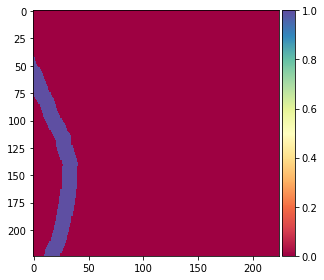

944


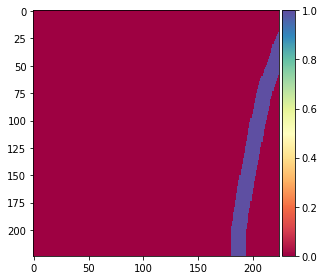

945


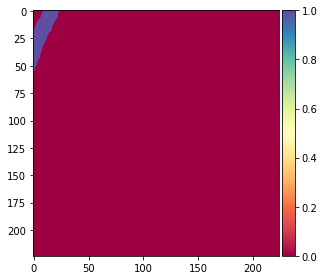

In [19]:
for ix in range(0,1000):
#ix = 75
#imshow(np.squeeze(X_train[ix]))
#plt.show()
    if(Y_test[ix].sum()>500):
        print(ix)
        imshow(np.squeeze(Y_test[ix]),cmap=plt.cm.Spectral)
        plt.show()
#imshow(np.squeeze(preds_test_t[ix]),cmap=plt.cm.Spectral)
#plt.show()
    #imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
    #plt.show()

In [11]:
mappedResult.sum()

2866413.0

In [25]:
X_testRGB = np.load("X_testRGB.npy")

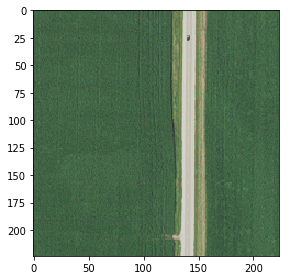

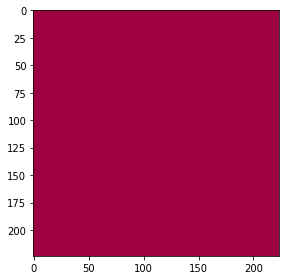

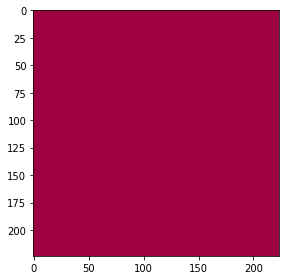

In [46]:
import random
ix=random.randint(300,900)
imshow(X_testRGB[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]),cmap=plt.cm.Spectral)
plt.show()
imshow(np.squeeze(mappedResult[ix]),cmap=plt.cm.Spectral)
plt.show()